<a href="https://colab.research.google.com/github/Felipanjos/a3_ia_2022.2/blob/main/Projeto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/datasets/michaelbryantds/cpu-and-gpu-product-data

### Análise e Entendimento do Problema:

#### Especificação do objetivo geral e dos objetivos específicos

O Objetivo geral do projeto é identificar a relação entre a quantidade dos transistors presentes nos processadores e qual a influência que o tamanho, TDP, entre outras características tem sob o processamento. Dentre os objetivos específicos está o tratamento das informações removendo os outliers, padronizando os dados, analisando as alterações, entre outros.

### a. Especificação do tipo de problema: Quanto à Supervisão, Quanto à Tarefa, Quanto ao Modo;

À FAZER 


b. Especificação das Medidas de Desempenho (para Classificação ou Regressão)


Como metódos de desempenho, os principais utilizados no nosso projeto, se tratam de acurácia para a Classicação e erro quadrático médio para Regressão, esses metódos, são extremamente importantes, pois é através deles que é possível observar o quão precisas estão sendo as predições realizadas pela máquina, por serem duas formas diferentes de Aprendizado de máquina supervisionado, cada um possui seu próprio método de desempenho, para a classificação usaremos o principal citado anteriormente, acurácia, se trata de um indicador da performance geral do modelo, contando quantas classificações foram feitas corretamente, para ser calculado, se torna necessário utilizar a Matriz de confusão, identificando os verdadeiros positivos, falso negativos, falso positivos e verdadeiros negativos, através desses dados é possível montar a Matriz e utilizar a formúla VP+VN/VP+VN+FP+FN para assim medir a acurácia do modelo, já para a regressão utilizaremos o erro quadrático médio, esse método carrega como objetivo encontrar a diferença dos valores iniciais com os valores preditos, quanto mais alta a diferença, maior o problema do modelo, pois os valores encontrados não estão sendo precisos, essa média é calculada através da diferença do valor predito para o valor real, o resultado é elevado ao quadrado, fazendo isso para todos os pontos, como já dito, quanto maior o resultado, mais pobre estão sendo as predições.

##### Hipotese

Com o avanço tecnológico observa-se um crescimento exponencial na quantidade de transistores em CPU's em função do tempo. De forma inversamente proporcional, é perceptível a redução do tamanho dos componentes. Lei de Moore

# 2.3 Requisitos da Análise de Dados:

#### Dependências

In [342]:
import pandas as pd
import numpy as np
import random
import string
import sklearn
from itertools import groupby
import plotly.express as px
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as sts
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### Carregando Dataset

In [359]:
df = pd.read_csv('chip_dataset.csv', index_col=0)

### Excluindo colunas sem utilidade

########### Explicação

In [354]:
df.drop('FP16 GFLOPS', axis=1, inplace=True)
df.drop('FP32 GFLOPS', axis=1, inplace=True)
df.drop('FP64 GFLOPS', axis=1, inplace=True)

### Inserindo problemas

##### Selecionando coluna aleatória

In [263]:
# escolhendo uma coluna aleatoriamente
random.seed(13)
n = random.randrange(0,len(df.columns))
coluna_aleatoria = df.columns[n]
coluna_aleatoria

'TDP (W)'

In [141]:
df.head()

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD


##### a) Selecionando 3% dos dados

In [264]:
p_3 = round(df.shape[0] * 3 / 100)
p_3

146

##### a) Excluindo 3% dos dados aleatoriamente

In [265]:
reg_excluidos = df.sample(n=p_3)
reg_exc_index = reg_excluidos.index.array
df.loc[reg_exc_index, coluna_aleatoria] = np.nan

In [266]:
# listando alterações
df.loc[reg_exc_index]

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
2831,AMD Radeon Pro WX 7100,GPU,2016-11-10,14.0,NaN,232.0,5700.0,1188.0,GF,AMD
215,AMD FX-6120,CPU,2012-10-23,32.0,NaN,315.0,1200.0,3600.0,Unknown,AMD
3251,NVIDIA Quadro M3000 SE,GPU,2016-10-02,28.0,NaN,398.0,5200.0,823.0,TSMC,NVIDIA
3991,NVIDIA GeForce 8300 GS,GPU,2007-04-17,80.0,NaN,127.0,210.0,459.0,TSMC,NVIDIA
882,AMD Opteron 144,CPU,2004-05-18,130.0,NaN,193.0,106.0,1800.0,Unknown,AMD
...,...,...,...,...,...,...,...,...,...,...
4339,AMD Radeon HD 6770M Mac Edition,GPU,2011-01-28,40.0,NaN,104.0,716.0,725.0,TSMC,AMD
1153,Intel Xeon 3.4,CPU,2004-06-28,90.0,NaN,135.0,155.0,3400.0,Intel,Intel
2139,Intel Core Solo ULV U1300,CPU,2006-04-19,65.0,NaN,90.0,151.0,1066.0,Intel,Intel
4345,AMD Radeon R7 250,GPU,2013-10-08,28.0,NaN,77.0,950.0,1000.0,TSMC,AMD


##### a) Alterando 3% dos dados aleatoriamente

In [267]:
def gerar_string_aleatoria():
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters) for i in range(10)) 

def gerar_numero_aleatorio():
  return random.randint(0, 999)

In [268]:
# listando indexes que sofrerão alteração na coluna aleatória
df_selecao_nao_nulo = df[~df[coluna_aleatoria].isnull()]
reg_alterados = df_selecao_nao_nulo.sample(n=p_3)
reg_alter_index = reg_alterados.index.array

In [269]:
# inserindo alterações na coluna aleatória
colunas_numericas = df.describe().columns

if coluna_aleatoria in colunas_numericas:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_numero_aleatorio()
else:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_string_aleatoria()

In [270]:
# listando alterações
df.loc[reg_alter_index]

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
1338,AMD Opteron 242,CPU,2003-04-22,130.0,297.0,193.0,106.0,1600.0,Unknown,AMD
3603,NVIDIA Tesla S1070,GPU,2008-06-01,55.0,701.0,470.0,1400.0,610.0,TSMC,NVIDIA
2664,AMD Radeon R9 380 OEM,GPU,2015-05-05,28.0,931.0,366.0,5000.0,918.0,TSMC,AMD
530,Intel Pentium G640,CPU,2012-06-03,32.0,700.0,131.0,504.0,2800.0,Intel,Intel
1128,AMD Sempron 3000+,CPU,2004-11-23,90.0,821.0,NaN,63.0,1800.0,Unknown,AMD
...,...,...,...,...,...,...,...,...,...,...
1471,Intel Core i3-4370,CPU,2014-07-01,22.0,359.0,177.0,1400.0,3800.0,Intel,Intel
1359,Intel Xeon Silver 4116,CPU,2017-07-11,14.0,207.0,NaN,8000.0,2100.0,Intel,Intel
4632,NVIDIA GeForce RTX 3070 Max-Q,GPU,2021-01-12,8.0,722.0,392.0,17400.0,780.0,Samsung,NVIDIA
1907,Intel Xeon Platinum 8260M,CPU,2018-12-11,14.0,874.0,NaN,8000.0,2400.0,Intel,Intel


#### Tratamento de registros nulos em colunas descritivas. Estratégia adotada: exclusão.

In [271]:
# Exlusão dos registros nulos nas colunas categoricas
colunas_descritivas = [x for x in list(df.columns) if x not in list(df.describe().columns)]
for col in colunas_descritivas:
    df = df[pd.notnull(df[col])]

df.reset_index(drop=True, inplace=True)

#### Tratamento de registros duplicados. Estratégia: exclusão.

In [274]:
df.duplicated().sum()

0

In [273]:
df.drop_duplicates(inplace=True)

#### Tratamento de registros nulos em colunas numéricas. Estratégia adotada: inserção da média.

In [280]:
df.isnull().sum()

Product                  0
Type                     0
Release Date             0
Process Size (nm)        0
TDP (W)                  0
Die Size (mm^2)          0
Transistors (million)    0
Freq (MHz)               0
Foundry                  0
Vendor                   0
dtype: int64

In [277]:
def imputer_mean(coluna):
    df[coluna] = df[coluna].fillna(df[coluna].mean())
    
for col in list(df.describe().columns):
    imputer_mean(col)

#### Divisão (Amostragem Estratificada)

In [364]:
# A amostragem estratificada classifca a quantidade de transistors em ranks, sendo assim possível realizar a contagem da quantidade de processadores que possuem um range da quantidade 
# de transistors

# < 250:                Rank F
# >= 250 & < 500:       Rank E
# >= 500 & < 1000:      Rank D
# >= 1000 & < 2000:     Rank C
# >= 2000 & < 6000:     Rank B
# >= 6000 & < 15000:    Rank A
# >= 15000 & < 30000:   Rank S 
# > 30000:              Rank S+ 

In [362]:
ranges = [0, 250, 500, 1000, 2000, 6000, 15000, 30000, np.inf]
tiers = ['F', 'E', 'D', 'C', 'B', 'A', 'S', 'S+']

df['Rank'] = pd.cut(df['Transistors (million)'], bins = ranges, labels = tiers)
df.reset_index(inplace=True)

In [363]:
df['Rank'].value_counts()

F     1421
C      728
B      616
D      574
E      490
A      246
S       60
S+       8
Name: Rank, dtype: int64

In [366]:
# Com base no gráfico é possível concluir que, nesta base de dados, os processadores com menos de 250 transistores são maioria, seguidos pelos de 1000 a 2000.

<AxesSubplot: xlabel='Rank', ylabel='count'>

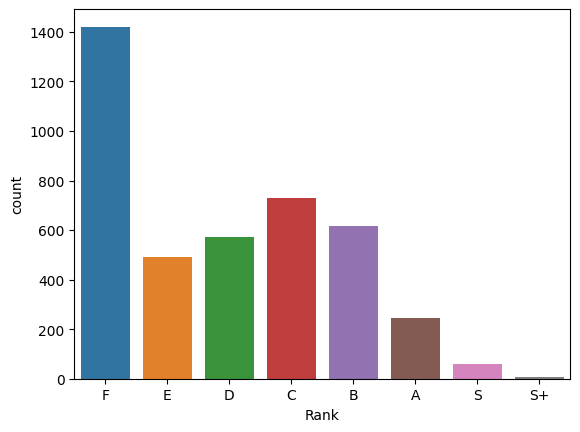

In [365]:
sns.countplot(x='Rank', data=df, order=tiers)

### Exploração 

##### Busca de correlações (Coeficientes de correlação)

In [367]:
# A correlação de Pearson é utilizada para identificar as colunas que possuem maior relação com a coluna em análise, neste caso 'Transistors (million)'.

In [285]:
colunas_para_calculo = df.describe().columns
print('Coeficiente de correlação de Pearson entre a coluna Die Size (mm^2) e:')

coor_dict = {}
r_list = []

for value in df.corr()['Die Size (mm^2)']:
    if value == 1:
        r = 'relação linear perfeita e positiva'
    elif value == 0:
        r = 'inexistência linear'
    elif value == -1:
        r = 'relação linear perfeita e negativa'
    elif value > 0:
        r = 'relação linear positiva'
    elif value < 0:
        r = 'relação linear negativa'

    r_list.append(r)

print(df.corr(method='pearson', min_periods=1)['Transistors (million)'], '\n')

count = 0
for col in colunas_para_calculo: 
    coor_dict[col] = r_list[count]
    print(f'{col}: {coor_dict[col]}')
    count += 1

Coeficiente de correlação de Pearson entre a coluna Transistors (million) e:
Process Size (nm)       -0.383867
TDP (W)                  0.274891
Die Size (mm^2)          0.628343
Transistors (million)    1.000000
Freq (MHz)               0.015541
Name: Transistors (million), dtype: float64 

Process Size (nm): relação linear negativa
TDP (W): relação linear positiva
Die Size (mm^2): relação linear positiva
Transistors (million): relação linear perfeita e positiva
Freq (MHz): relação linear positiva


C:\Users\amr\AppData\Local\Temp\ipykernel_13856\3684446859.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\amr\AppData\Local\Temp\ipykernel_13856\3684446859.py:21: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## Análise dos Dados

In [297]:
df_an = df.copy()
df_an.set_index('Release Date', inplace=True)
df_an.sort_index(inplace=True)

In [298]:
df_cpu = df_an[df_an["Type"] == "CPU"]
df_gpu = df_an[df_an["Type"] == "GPU"]

### Analise da quantidade dos Transistors vs Tamanho do Núcleo por Anos

#### CPU

In [310]:
fig_transistors = make_subplots()
fig_die = make_subplots()

# Add traces
fig_transistors.add_trace(
    go.Scatter(x= df_an.index, y=df_cpu["Transistors (million)"] ,name= "CPU")
)
# Add figure title
fig_transistors.update_layout(
    title_text="CPU vs Transistors (million) evolution over years"
)
# Set x-axis title
fig_transistors.update_xaxes(title_text="Years")
# Set y-axes titles
fig_transistors.update_yaxes(title_text="<b>Transistors (million)", secondary_y=False)

# Add traces
fig_die.add_trace(
    go.Scatter(x= df_an.index, y=df_cpu["Die Size (mm^2)"] ,name= "CPU")
)
# Add figure title
fig_die.update_layout(
    title_text="CPU vs Die Size (mm^2) evolution over years"
)
# Set x-axis title
fig_die.update_xaxes(title_text="Years")
# Set y-axes titles
fig_die.update_yaxes(title_text="<b>Die Size (mm^2)", secondary_y=False)

fig_transistors.show()
fig_die.show()

#### GPU

In [311]:
fig_transistors = make_subplots()
fig_die = make_subplots()

# Add traces
fig_transistors.add_trace(
    go.Scatter(x= df_an.index, y=df_gpu["Transistors (million)"] ,name= "GPU")
)
# Add figure title
fig_transistors.update_layout(
    title_text="GPU vs Transistors (million) evolution over years"
)
# Set x-axis title
fig_transistors.update_xaxes(title_text="Years")
# Set y-axes titles
fig_transistors.update_yaxes(title_text="<b>Transistors (million)", secondary_y=False)

# Add traces
fig_die.add_trace(
    go.Scatter(x= df_an.index, y=df_gpu["Die Size (mm^2)"] ,name= "GPU")
)
# Add figure title
fig_die.update_layout(
    title_text="GPU vs Die Size (mm^2) evolution over years"
)
# Set x-axis title
fig_die.update_xaxes(title_text="Years")
# Set y-axes titles
fig_die.update_yaxes(title_text="<b>Die Size (mm^2)", secondary_y=False)

fig_transistors.show()
fig_die.show()

##### Analise de Transistors x Die Size

#### Análise de frquência

In [316]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x= df_cpu.index, y=df_cpu["Freq (MHz)"] ,name= "CPU")
)

fig.add_trace(
    go.Scatter(x= df_gpu.index,y= df_gpu["Freq (MHz)"], name= "GPU")
)

# Add figure title
fig.update_layout(
    title_text="CPU/GPU vs Frequency (MHz) evolution over years"
)

# Set x-axis title
fig.update_xaxes(title_text="Years")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Freq (MHz)</b>", secondary_y=False)

fig.show()

#### Analise Proccess Size

In [30]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x= df_cpu.index, y=df_cpu["Process Size (nm)"] ,name= "CPU")
)

fig.add_trace(
    go.Scatter(x= df_gpu.index,y= df_gpu["Process Size (nm)"], name= "GPU")
)

# Add figure title
fig.update_layout(
    title_text="CPU/GPU vs Process Size (nm) evolution over years"
)

# Set x-axis title
fig.update_xaxes(title_text="Years")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Process Size (nm)</b>", secondary_y=False)

fig.show()

### Modelo

#### Divisão de conjuntos, treino e teste

In [334]:
def amostragem_estratificada(test_set):
    return (test_set['Rank'].value_counts() / len(test_set)) 

In [335]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df, df['Rank']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [ ]:
amostragem_estratificada(strat_train_set)

In [336]:
amostragem_estratificada(strat_test_set)

C     0.295789
F     0.250526
E     0.138947
B     0.128421
D     0.120000
A     0.051579
S     0.012632
S+    0.002105
Name: Rank, dtype: float64

In [337]:
strat_train_set.drop(columns=['Rank'], inplace=True)
strat_test_set.drop(columns=['Rank'], inplace=True)

##### Padronização dos dados

In [45]:
num_attribs = list(df.describe(include=np.number))

In [46]:
padronizacao_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

##### Atributos categóricos

In [47]:
cat_attribs = ['Vendor']

##### Full Pipeline

In [71]:
full_pipeline = ColumnTransformer([
        ('num_attr', padronizacao_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs),
    ])

In [72]:
strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set)

In [73]:
strat_test_set_prepared = full_pipeline.fit_transform(strat_test_set)

##### Treinamento do modelo - Regressão Linear

In [368]:
cpu_labels = strat_train_set['Transistors (million)'].copy()
x = df[['Transistors (million)']]
y = df[['Die Size (mm^2)']]

lin_reg = LinearRegression()
lin_reg.fit(x, y)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
plt.scatter(x, y)

In [116]:
c_angular = lin_reg.coef_
c_linear = lin_reg.intercept_

NameError: name 'lin_reg' is not defined

In [ ]:
plt.scatter(x, y)
plt.plot(x, c_linear + c_angular * x, color='red')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

cpu_predictions = lin_reg.predict(cpu_prepared)
lin_rmse = mean_squared_error(cpu_labels, cpu_predictions, squared=False)

In [ ]:
cpu_predictions

In [ ]:
round(lin_rmse, 2)

# 2.4 Requisitos da Construção dos Modelos e Aprendizado de Máquina 

### Seleção dos Modelos